In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. Read data

In [29]:
df = pd.read_csv('IMDB Dataset.csv')

In [30]:
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


### 2. Text Preprocessing

In [31]:
# convert positive to 1 and negative to 0
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_num = ordinal_encoder.fit_transform(df[['sentiment']])
df['num_sentiment'] = df_num

In [32]:
df.drop(['sentiment'], axis=1, inplace=True)

In [33]:
df.head(2)

,review,num_sentiment
0,One of the other reviewers has mentioned that ...,1.0
1,A wonderful little production. <br /><br />The...,1.0


In [34]:
# Remove html coding
df['review'] = df['review'].str.replace('<.*?>','')

In [35]:
# Remove all puncuation and symbols
df['review'] = df['review'].str.replace('[^\w\s]','')

In [36]:
# Make everything lower case
df['review'] = df['review'].str.lower()

#### 2.1 Data without Removing Stopwords

In [37]:
df_wsw = df.copy()
df_wosw = df.copy()

In [38]:
# Tokenize
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [39]:
def lemmatize_text(text):
    
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [40]:
df_wosw['lemma_review'] = df_wosw.review.apply(lemmatize_text)

In [41]:
df_wosw.head(2)

,review,num_sentiment,lemma_review
0,one of the other reviewers has mentioned that ...,1.0,one of the other reviewer ha mentioned that af...
1,a wonderful little production the filming tech...,1.0,a wonderful little production the filming tech...


#### 2.2 Removing Stopwords

In [42]:
# Remove stop words
import spacy

sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
# # After seeing the word counts, update stop words
sp.Defaults.stop_words |= {'movie', 'film'}

In [43]:
df_wsw['review'] = df_wsw['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

In [44]:
df_wsw['lemma_review'] = df_wsw.review.apply(lemmatize_text)

In [45]:
df_wsw.head(2)

,review,num_sentiment,lemma_review
0,reviewers mentioned watching 1 oz episode youl...,1.0,reviewer mentioned watching 1 oz episode youll...
1,wonderful little production filming technique ...,1.0,wonderful little production filming technique ...


In [46]:
# keep 50% for the training set and 25% both for the validation and the test set.
from sklearn.model_selection import train_test_split

features = df_wsw.drop(['num_sentiment', 'review'], axis=1)
label = df_wsw['num_sentiment']

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.18, random_state=42)

print("Data distribution:\n- Train: {} \n- Test: {}".format(len(X_train),len(X_test)))

Data distribution:
- Train: 41000 
- Test: 9000


In [47]:
# Reset the index in X_train so we can get the mean of review length for the training set
X_train.reset_index(drop=True, inplace=True)

### tensorflow stuff

In [48]:
tokenizer = Tokenizer(num_words=None, filters='', lower=False, split=' ')
tokenizer.fit_on_texts(X_train['lemma_review'])

In [49]:
vocab_size = len(tokenizer.word_index) + 1

In [50]:
encoded_docs = tokenizer.texts_to_sequences(X_train['lemma_review'])

In [51]:
rev_len=[]
for i in range(len(X_train['lemma_review'])):
    rev_len.append(len(X_train['lemma_review'][i]))
max_length = int(round(sum(rev_len)/len(rev_len),0))

In [52]:
padded_sequence = pad_sequences(encoded_docs, maxlen=max_length)

## Modeling

In [53]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

opt = RMSprop(learning_rate=.01)
METRICS = ['accuracy', Precision(name='precision'), Recall(name='recall')]

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=METRICS)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           5914592   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 5,931,243
Trainable params: 5,931,243
Non-trainable params: 0
_________________________________________________________________
None


## Train - val_split = .2, epochs=5, batch_size=64, optimizer=RMSprop: learn_rate=.01

In [54]:
history = model.fit(padded_sequence, y_train, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
513/513 [==============================] - 1467s 3s/step - loss: 0.4279 - accuracy: 0.8116 - precision: 0.8118 - recall: 0.8097 - val_loss: 0.3546 - val_accuracy: 0.8577 - val_precision: 0.9249 - val_recall: 0.7785
Epoch 2/5
513/513 [==============================] - 1466s 3s/step - loss: 0.2430 - accuracy: 0.9079 - precision: 0.9028 - recall: 0.9136 - val_loss: 0.3011 - val_accuracy: 0.8812 - val_precision: 0.9148 - val_recall: 0.8407
Epoch 3/5
513/513 [==============================] - 1469s 3s/step - loss: 0.1730 - accuracy: 0.9376 - precision: 0.9369 - recall: 0.9380 - val_loss: 0.3468 - val_accuracy: 0.8746 - val_precision: 0.9178 - val_recall: 0.8229
Epoch 4/5
513/513 [==============================] - 1470s 3s/step - loss: 0.1338 - accuracy: 0.9549 - precision: 0.9541 - recall: 0.9556 - val_loss: 0.2923 - val_accuracy: 0.8879 - val_precision: 0.8715 - val_recall: 0.9100
Epoch 5/5
513/513 [==============================] - 1468s 3s/step - loss: 0.1133 - accuracy: 0.9612

In [55]:
# Save model
model.save('IMDB_5.h5')

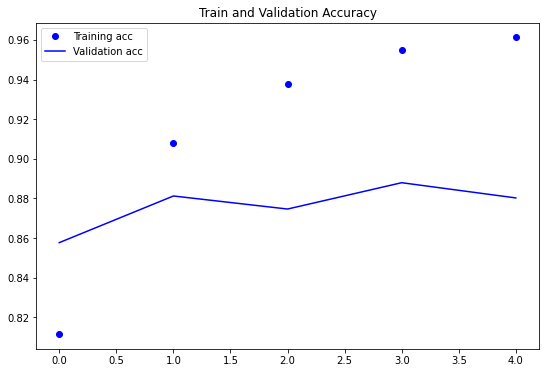

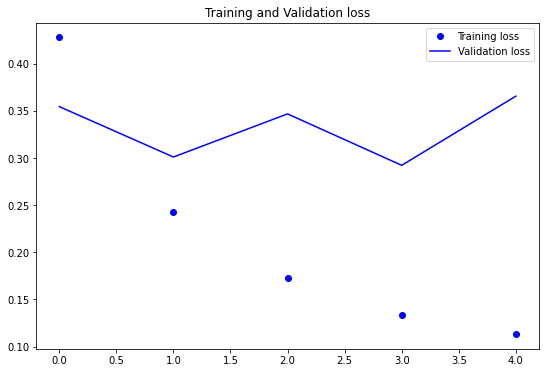

In [56]:
plt.figure(figsize=(9,6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.figure(figsize=(9,6))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()